# Workflow to Rasterize the Streams from NDH and align them to the terrain

Following the workflow from https://web.corral.tacc.utexas.edu/nfiedata/docs/NFIE-CFIM-JAWRA-YanLiu-20170619.pdf (slide 27)

Part of the bigger workflow: https://web.corral.tacc.utexas.edu/nfiedata/docs/hand-workflow.png

https://www.hydroshare.org/resource/73aaa3efcda2465ba6227f535400f36b/


In [55]:
import os
import rioxarray
import xrspatial
import numpy as np
import pandas as pd
import geopandas as gpd
from pygeohydro import WBD
import py3dep
from pynhd import NHD, WaterData
import pynhd
import matplotlib.pyplot as plt
import xrspatial
import whitebox
from valleys.utils import setup_wbt
from shapely.geometry import Point

In [2]:
def get_dem_and_flowlines(huc12):
    print('water boundary')
    wbd = WBD("huc12")
    boundary = wbd.byids("huc12", huc12)
    boundary_reprojected = boundary.to_crs(3310)

    print('getting dem')
    dem = py3dep.get_map("DEM", boundary.geometry.iloc[0], resolution=10, geo_crs=boundary.crs, crs=4326)
    dem = dem.rio.reproject(3310)

    print('flowlines medium resolution')
    nhd_mr = NHD("flowline_mr")
    flowlines_mr = nhd_mr.bygeom(boundary.geometry.iloc[0].bounds)
    flowlines_mr = flowlines_mr.to_crs(3310)
    flowlines_mr = flowlines_mr.clip(boundary_reprojected.geometry.iloc[0])

    print('flowlines high resolution')
    nhd_hr = NHD("flowline_hr")
    flowlines_hr = nhd_hr.bygeom(boundary.geometry.iloc[0].bounds)
    flowlines_hr = flowlines_hr.to_crs(3310)
    flowlines_hr = flowlines_hr.clip(boundary_reprojected.geometry.iloc[0])
    return dem, flowlines_mr, flowlines_hr

In [49]:
wbt = setup_wbt("~/opt/WBT/", "../data/wb_outputs/")
wbt.set_verbose_mode(False)
def my_callback(value):
    if not "%" in value:
        print(value)
wbt.set_default_callback(my_callback)

In [3]:
dem, flow, flow_hr = get_dem_and_flowlines(180600060101)

water boundary
getting dem


/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xarray/core/dataarray.py:905: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xarray/core/dataarray.py:905: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xarray/core/dataarray.py:905: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


flowlines medium resolution
flowlines high resolution


In [53]:
# save dem to file
dem.rio.to_raster(os.path.join(wbt.work_dir, 'dem.tif'))

# save flowlines to file
flow.to_file(os.path.join(wbt.work_dir, 'flow.shp'))

/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/ipykernel_9873/2920228301.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  flow.to_file(os.path.join(wbt.work_dir, 'flow.shp'))


In [52]:
# need 'breachDepressions', 'flowdir', 'flowacc'
wbt.breach_depressions_least_cost(
    'dem.tif', 
    'breached.tif', 
    dist=1000, 
    max_cost=None, 
    min_dist=True, 
    flat_increment=None, 
    fill=True, 
)

wbt.d8_pointer(
    'breached.tif', 
    'flow_dir.tif', 
    esri_pntr=False, 
)

wbt.d8_flow_accumulation(
    'flow_dir.tif', 
    'flow_acc.tif', 
    out_type="cells", 
    log=False, 
    clip=False, 
    pntr=True, 
    esri_pntr=False, 
)

0

<Axes: >

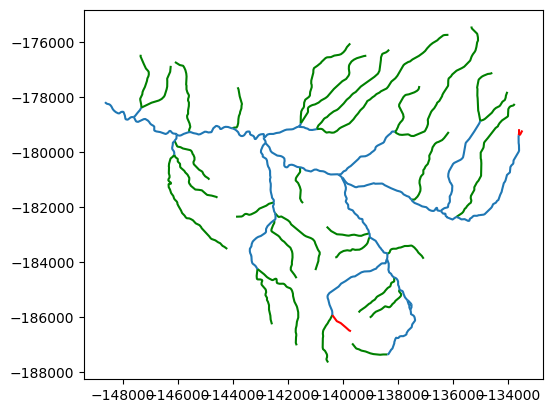

In [83]:
fig, ax = plt.subplots()

flow.loc[(flow['StartFlag'] == 1) & (flow['LENGTHKM'] > 1)].plot(ax=ax, color='green')
flow.loc[(flow['StartFlag'] == 1) & (flow['LENGTHKM'] < 1)].plot(ax=ax, color='red')
flow.loc[flow['StartFlag'] == 0].plot(ax=ax)

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


<Axes: >

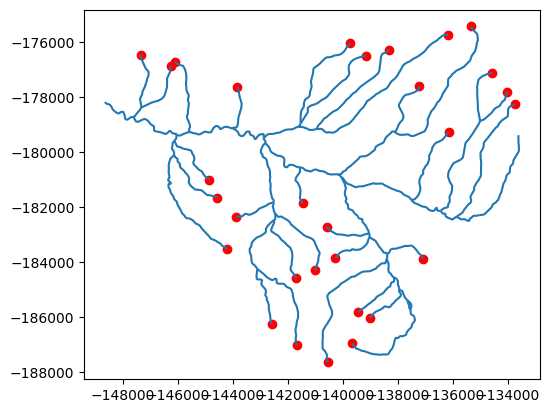

In [91]:
# get channel head coordinates as point files to be used in 'TraceDownSlopeFlowPaths'
fig, ax = plt.subplots()

filtered_flow = flow.loc[~((flow['StartFlag'] == 1) & (flow['LENGTHKM'] < 1))]


seed_points = filtered_flow.loc[flow['StartFlag'] == 1]['geometry'].apply(lambda x: Point(x.coords[0]))
filtered_flow.plot(ax=ax)
seed_points.plot(ax=ax, color='red')

In [93]:
seed_points.to_file(os.path.join(wbt.work_dir, "head_points.shp"))

In [94]:
# snap points
wbt.snap_pour_points(
    "head_points.shp",
    "flow_acc.tif",
    "snapped_head_points.shp",
    snap_dist=50)

# TraceDownSlopeFlowPaths
wbt.trace_downslope_flowpaths(
    "snapped_head_points.shp",
    "flow_dir.tif",
    "streams.tif")

# RasterStreamsToVector
wbt.raster_streams_to_vector(
    "streams.tif",
    "flow_dir.tif",
    "streams.shp")

0

In [96]:
streams = gpd.GeoDataFrame.from_file(os.path.join(wbt.work_dir, "streams.shp"))

In [105]:
# usse streams tif for HAND

In [108]:
streams

,FID,STRM_VAL,geometry
0,1,1.0,"LINESTRING (-140525.627 -187664.260, -140515.6..."
1,2,4.0,"LINESTRING (-138337.475 -183937.408, -138307.5..."
2,3,5.0,"LINESTRING (-138397.424 -183707.602, -138417.4..."
3,4,6.0,"LINESTRING (-139006.909 -183078.134, -139006.9..."
4,5,7.0,"LINESTRING (-139066.859 -182928.260, -139066.8..."
5,6,11.0,"LINESTRING (-140006.065 -180929.948, -140016.0..."
6,7,13.0,"LINESTRING (-140125.964 -180860.007, -140145.9..."
7,8,14.0,"LINESTRING (-141524.783 -180570.252, -141534.7..."
8,9,19.0,"LINESTRING (-142813.694 -179651.028, -142813.6..."
9,10,23.0,"LINESTRING (-142883.635 -179421.223, -142883.6..."


In [107]:
len(flow)

73